<a href="https://colab.research.google.com/github/SiPilip/diabetes-counter-propogation-network/blob/main/diabetes_using_cpn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv("/content/diabetes.csv")

In [7]:
# Ganti 0 dengan NaN
# Kolom yang tidak boleh bernilai 0
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[invalid_zero_cols] = df[invalid_zero_cols].replace(0, pd.NA)

# 2. Tampilkan ringkasan awal
print("Jumlah data awal:", df.shape)
print("\nJumlah missing value per kolom:\n", df.isnull().sum())

df.head()

Jumlah data awal: (100, 9)

Jumlah missing value per kolom:
 Pregnancies                  0
Glucose                      1
BloodPressure                6
SkinThickness               32
Insulin                     55
BMI                          4
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,<NA>,33.6,0.627,50,1
1,1,85,66,29,<NA>,26.6,0.351,31,0
2,8,183,64,<NA>,<NA>,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
# Imputasi nilai NaN dengan median kolom masing-masing
for col in invalid_zero_cols:
    df[col] = df[col].fillna(df[col].median())

# Simpan DataFrame hasil preprocessing ke file CSV
df.to_csv("preprocessed_data_before_normalization.csv", index=False)

# Normalisasi fitur kecuali target (Outcome)
# features = df.drop(columns='Outcome')
# scaler = StandardScaler()
# df[features.columns] = scaler.fit_transform(features)

# (Opsional) Pisahkan fitur dan target
X = df.drop(columns='Outcome')
y = df['Outcome']

df.to_csv("preprocessed_data_after_normalization.csv", index=False)

# Tampilkan hasil akhir
print(X.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    125.0  33.6   
1            1     85.0           66.0           29.0    125.0  26.6   
2            8    183.0           64.0           29.0    125.0  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33  


<ipython-input-8-f2bed5d7a978>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].median())
<ipython-input-8-f2bed5d7a978>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].median())
<ipython-input-8-f2bed5d7a978>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[c

In [9]:
# Spliting data

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X
y_train = y

X_test = X
y_test = y

In [10]:
# Konversi fitur (X) dari DataFrame ke Tensor
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

# Konversi label (y) dari Series ke Tensor
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

# Jika label dalam bentuk one-hot, ubah ke index kelas
if y_train.ndim == 2:
    y_train = torch.argmax(y_train, dim=1)
if y_test.ndim == 2:
    y_test = torch.argmax(y_test, dim=1)

# Pastikan tipe data label adalah long (untuk CrossEntropyLoss)
y_train = y_train.long()
y_test = y_test.long()


### Counter Propagation Network --> CPN

In [11]:
from torch import nn
import torch.nn.functional as F

In [12]:
import torch
from torch import nn

class CPN(nn.Module):
    def __init__(self, input_size: int, kohonen_size: int, output_size: int):
        super(CPN, self).__init__()
        # Kohonen layer (unsupervised)
        self.kohonen = nn.Linear(input_size, kohonen_size, bias=False)

        # Grossberg layer (supervised)
        self.grossberg = nn.Linear(kohonen_size, output_size)

    def forward(self, x):
        # Kohonen layer - winner takes all (argmax activation)
        kohonen_output = self.kohonen(x)
        winner_index = torch.argmax(kohonen_output, dim=1)
        one_hot_output = torch.zeros_like(kohonen_output)
        one_hot_output[torch.arange(x.size(0)), winner_index] = 1.0

        # Grossberg layer - supervised output
        output = self.grossberg(one_hot_output)
        return output

In [13]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CPN(input_size=X_train.shape[1], kohonen_size=10, output_size=len(torch.unique(y_train)))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import csv
import os

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               epoch: int) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0
    manual_results = []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        with torch.no_grad():
          for i in range(X.size(0)):  # iterasi setiap sampel dalam batch
              sample_X = X[i].unsqueeze(0)  # jadikan shape (1, input_dim)
              sample_y = y[i].item()

              kohonen_output = model.kohonen(sample_X)
              winner_index = torch.argmax(kohonen_output, dim=1).item()
              z = torch.zeros_like(kohonen_output)
              z[0, winner_index] = 1.0
              grossberg_output = model.grossberg(z)
              pred_y = torch.argmax(grossberg_output, dim=1).item()

              y_true_onehot = torch.zeros(1, grossberg_output.shape[1], device=device)
              y_true_onehot[0, sample_y] = 1
              error = grossberg_output - y_true_onehot

              W_before = model.grossberg.weight.data.clone().detach().cpu()
              alpha = 1e-2
              delta_W = -alpha * z.T @ error

              if torch.abs(error).max() >= 1e-3:
                  W_after = W_before + delta_W.T.cpu()
              else:
                  W_after = W_before  # Tidak berubah jika error kecil

              result = {
                  "epoch": epoch + 1,
                  **{f"x{j+1}": sample_X[0][j].item() for j in range(sample_X.shape[1])},
                  "y_true": sample_y,
                  "y_pred": pred_y,
              }

              for j in range(grossberg_output.shape[1]):
                  result[f"error_{j}"] = error[0][j].item()

              for j in range(grossberg_output.shape[1]):
                  for k in range(z.shape[1]):
                      # result[f"w{j}_{k}_before"] = W_before[j][k].item()
                      result[f"w{j}_{k}_after"] = W_after[j][k].item()
                      result[f"delta_w{j}_{k}"] = delta_W.T[j][k].item()

              manual_results.append(result)

    # Simpan ke CSV
    csv_path = "manual_cpn_forward_backward.csv"
    write_header = not os.path.exists(csv_path)

    if manual_results:
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=manual_results[0].keys())
            if write_header:
                writer.writeheader()
            writer.writerows(manual_results)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           epoch=epoch)  # ← dikirim ke sini

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [15]:
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6756 | train_acc: 0.5800 | test_loss: 0.6492 | test_acc: 0.6300
Epoch: 2 | train_loss: 0.6549 | train_acc: 0.6300 | test_loss: 0.6430 | test_acc: 0.6300
Epoch: 3 | train_loss: 0.6512 | train_acc: 0.6300 | test_loss: 0.6376 | test_acc: 0.6300
Epoch: 4 | train_loss: 0.6465 | train_acc: 0.6300 | test_loss: 0.6335 | test_acc: 0.6300
Epoch: 5 | train_loss: 0.6429 | train_acc: 0.6300 | test_loss: 0.6306 | test_acc: 0.6300


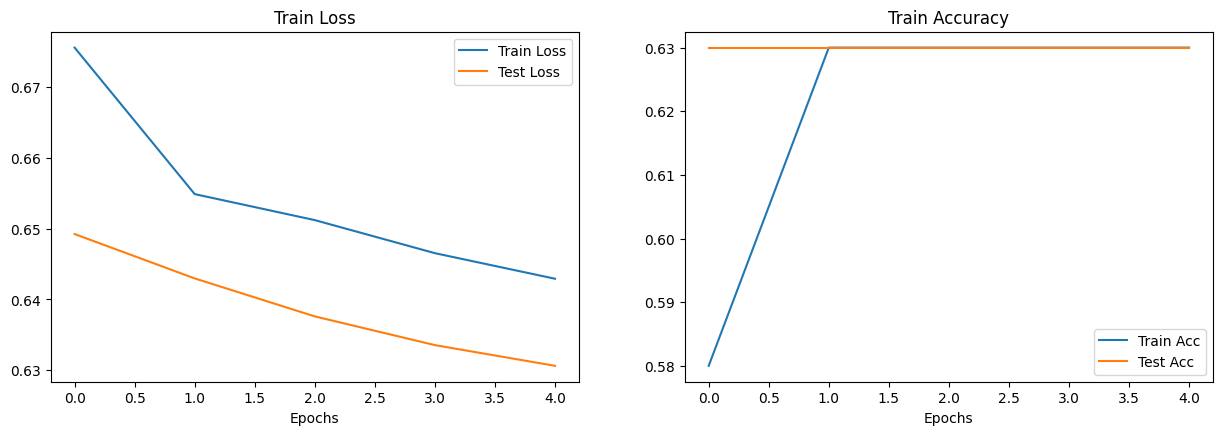

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Ubah hasil pelatihan menjadi DataFrame
model_df = pd.DataFrame(results)

# Setup plot
plt.figure(figsize=(15,10))

# Ambil jumlah epochs
epochs = range(len(model_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_df["train_loss"], label="Train Loss")
plt.plot(epochs, model_df["test_loss"], label="Test Loss")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,2)
plt.plot(epochs, model_df["train_acc"], label="Train Acc")
plt.plot(epochs, model_df["test_acc"], label="Test Acc")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [17]:
# # 6. Manual CPN calculation on 1 sample
# sample_X = X_train[0].unsqueeze(0)  # bentuk: [1, 8]
# sample_y = y_train[0].item()       # label asli (0 atau 1)

# with torch.no_grad():
#     # Forward Kohonen layer
#     kohonen_output = model.kohonen(sample_X)
#     winner_index = torch.argmax(kohonen_output, dim=1).item()

#     # Winner-take-all (one-hot)
#     z = torch.zeros_like(kohonen_output)
#     z[0, winner_index] = 1.0

#     # Forward Grossberg layer
#     grossberg_output = model.grossberg(z)
#     y_pred = torch.argmax(grossberg_output, dim=1).item()

#     # Hitung error terhadap one-hot target
#     y_true_onehot = torch.zeros_like(grossberg_output)
#     y_true_onehot[0, sample_y] = 1.0
#     error = grossberg_output - y_true_onehot  # bentuk: [1, 2]

# # Ambil bobot sebelum update
# W_before = model.grossberg.weight.data.clone().detach().T  # bentuk: [10, 2]

# # Learning rate
# alpha = 0.01

# # Hitung delta bobot: delta_W = -α * z^T @ error
# delta_W = -alpha * z.T @ error  # [10, 1] x [1, 2] = [10, 2]

# # Update bobot: W_after = W_before + delta_W
# W_after = W_before + delta_W

# # Simpan hasil dalam dict
# result = {
#     **{f"x{i+1}": sample_X[0][i].item() for i in range(8)},
#     "y_true": sample_y,
#     "y_pred": y_pred,
#     "error_0": error[0][0].item(),
#     "error_1": error[0][1].item()
# }

# # Tambahkan nilai bobot, delta, sebelum dan sesudah
# for i in range(10):  # 10 unit Kohonen
#     for j in range(2):  # 2 output class
#         result[f"w{i}_{j}_before"] = W_before[i][j].item()
#         result[f"w{i}_{j}_after"] = W_after[i][j].item()
#         result[f"delta_w{i}_{j}"] = delta_W[i][j].item()

# # Simpan ke CSV
# manual_df = pd.DataFrame([result])
# manual_df.to_csv("manual_cpn_forward_backward.csv", index=False)
